<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/MultiAgent_DissertationProject_v1_0ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import clip
  import stable_baselines3
  import sb3_contrib
  import pettingzoo
  from plot_image_grid import image_grid
except ModuleNotFoundError:
  !pip install git+https://github.com/openai/CLIP.git
  !pip install stable-baselines3[extra]
  !pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib
  !pip install pettingzoo
  !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [3]:
import pytorch3d

In [4]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [6]:
def load_mesh(input_path) -> Meshes:
  obj_filename = os.path.join(DATA_DIR, input_path)
  return load_objs_as_meshes([obj_filename], device=device)

In [7]:
fruit_mesh = load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
table_mesh = load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [9]:
import copy

from pytorch3d.renderer import (
  HardPhongShader
)

class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()
      self._prev_position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      self._prev_position = copy.deepcopy(self._position)
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)

    def reset_pos(self):
      self._position = copy.deepcopy(self._prev_position)

class Scene():
  def __init__(self, meshes: list, azim, elev, dist):
    self.AZIM = azim
    self.ELEV = elev
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = dist
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)
    self.device = device
    

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value).extend(self.num_cameras)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[0.0, 5.0, 7.0]])
    # return AmbientLights(device=self.device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=self.device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=256, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=HardPhongShader(
            device=self.device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [10]:
from PIL import Image

def get_pil_image(input):
  return Image.fromarray((input * 255).astype('uint8'))

def clip_sim_3(input: list, description: str):
  text = clip.tokenize(description).to(device)
  with torch.no_grad():
    text_features = model.encode_text(text)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarities = []
  for image_input in input:
    # image_input = get_pil_image(image_input[0, ..., :3])
    image_input = preprocess(image_input).unsqueeze(0).to(device)

    with torch.no_grad():
      image_features = model.encode_image(image_input).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    # print(similarity[0][0])
    similarities.append(similarity[0][0])
  return similarities

In [33]:
import functools
from gym.spaces import Box
from pettingzoo import ParallelEnv
from pettingzoo.utils import wrappers
from pettingzoo.utils import parallel_to_aec
from scipy.stats import mannwhitneyu

class RenderEnv(ParallelEnv):
  metadata = {"render_modes": ["human"], "name": "rps_v2"}

  def __init__(self, objs, guide, limit=None):
    """
    The init method takes in environment arguments and should define the following attributes:
    - possible_agents
    - action_spaces
    - observation_spaces

    These attributes should not be changed after initialization.
    """
    self.GUIDE_STRING = guide

    self.limit = limit
    self.rounds = 0

    self.camera_config = {
      'azim': torch.linspace(0, 180, 4),
      'elev': [45],
      'dist': 15.0
    }

    self.limit_box = [[-10,-1,-10],[10,10,10]]
    self.p_threshold = 0.1
    

    self.best = {}
    self.images = None

    self.possible_agents = ["object_" + str(r) for r in range(len(objs))]
    self.agents = self.possible_agents
    self.agent_mapping = dict(
        zip(self.agents, [copy.deepcopy(obj) for obj in objs])
    )

    self.scene = Scene(
      meshes=[a.mesh for a in list(self.agent_mapping.values())], 
      **self.camera_config
    )

    self.num_cameras = self.scene.num_cameras
    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.prev_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)

    self.limited = np.ones((len(self.agents))).astype(np.float32)

  # this cache ensures that same space object is returned for the same agent
  # allows action space seeding to work as expected
  @functools.lru_cache(maxsize=None)
  def observation_space(self, agent):
    # Gym spaces are defined and documented here: https://gym.openai.com/docs/#spaces
    return Box(low=-1, high=1, shape=(3,))

  @functools.lru_cache(maxsize=None)
  def action_space(self, agent):
    return Box(low=-1, high=1, shape=(3,))

  def render_scene(self) -> None:
      self.scene = Scene([a.mesh for a in list(self.agent_mapping.values())], **self.camera_config)
      self.images = self.scene.render()

  def clip_scores(self):
    self.render_scene()
    pil_images = [get_pil_image(img[..., :3]) for img in self.images]
    return clip_sim_3(pil_images, self.GUIDE_STRING)

  def limit_action(self, action, i):
    limited = False
    translation_result = [a+b for a,b in zip (list(self.agent_mapping.values())[i].position, action)]
    for i, val in enumerate(translation_result):
        if val < self.limit_box[0][i]:
            limited = True
        elif val > self.limit_box[1][i]:
            limited = True
    return limited

  def perform_test(self, a, b):
    stat, p = mannwhitneyu(a, b, alternative='greater',method='exact')
    return stat, p

  def get_reward(self, sim_matrix) -> int:
    rw = 0

    stat_best, p_best = self.perform_test(sim_matrix, self.best_sim_matrix)
    stat_prev, p_prev = self.perform_test(sim_matrix, self.prev_sim_matrix)
    # tmax = 20
    # tmin = 0
    # stat_best = (stat_best - tmin)/(tmax-tmin)
    # stat_prev = (stat_prev - tmin)/(tmax-tmin)

    if p_best <= self.p_threshold:
      self.best_sim_matrix = sim_matrix
      self.best["images"] = self.images
      self.best["scene"] = self.scene.scene

    rw += 1-p_best
    rw += 1-p_prev

    rw = (2 *(rw - -2)/(2- -2)) - 1

    self.prev_sim_matrix = sim_matrix

    return rw


  def take_action(self, i, action):
    limits = self.limit_action(action[:3], i)
    if limits:
      self.limited[i] = 0.0
    else:
      self.agent_mapping[self.agents[i]].translate(action)
    return self.agent_mapping[self.agents[i]].position


  def reset(self, seed=None):
    """
    Reset needs to initialize the `agents` attribute and must set up the
    environment so that render(), and step() can be called without issues.

    Here it initializes the `num_moves` variable which counts the number of
    hands that are played.

    Returns the observations for each agent
    """
    self.limited = np.ones((len(self.agents))).astype(np.float32)
    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.prev_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.rounds = 0
    observations = {agent: np.zeros(3).astype(np.float32) for agent in self.agents}
    return observations

  def step(self, actions):
    """
    step(action) takes in an action for each agent and should return the
    - observations
    - rewards
    - dones
    - infos
    dicts where each dict looks like {agent_1: item_1, agent_2: item_2}
    """
    done = False
    self.rounds +=1 

    # If a user passes in actions with no agents, then just return empty observations, etc.
    if not actions:
        self.agents = []
        return {}, {}, {}, {}

    if self.limit:
      env_done = self.rounds >= self.limit
    else:
      env_done = False
    dones = {agent: env_done for agent in self.agents}

    # current observation is just the other player's most recent action
    observations = {
        self.agents[i]: self.take_action(i, actions[self.agents[i]]) for i in range(len(self.agents))
    }

    sim_matrix = np.asarray(self.clip_scores()).astype(np.float32)

    overall_reward = self.get_reward(sim_matrix)

    rewards = { self.agents[i]: overall_reward * self.limited[i] for i in range(len(self.agents)) }

    self.limited = np.ones((len(self.agents))).astype(np.float32)
    # typically there won't be any information in the infos, but there must
    # still be an entry for each agent
    # infos = {agent: {} for agent in self.agents}

    infos = {}

    infos["images"] = self.images
    infos["best"] = self.best

    if env_done:
        self.agents = []

    return observations, rewards, dones, infos

In [12]:
fruit_object = SceneObject(fruit_mesh, scale=0.25)

table_object = SceneObject(table_mesh, scale=8)
table_object.position=[0,0,0]

In [34]:
env = RenderEnv([fruit_object, table_object], "A piece of fruit on top of a wooden table")
max_cycles = 1000

_infos = None
for step in range(max_cycles):
    actions = {agent: Box(low=-1, high=1, shape=(3,)).sample() for agent in env.agents}
    observations, rewards, dones, infos = env.step(actions)
    _infos = infos

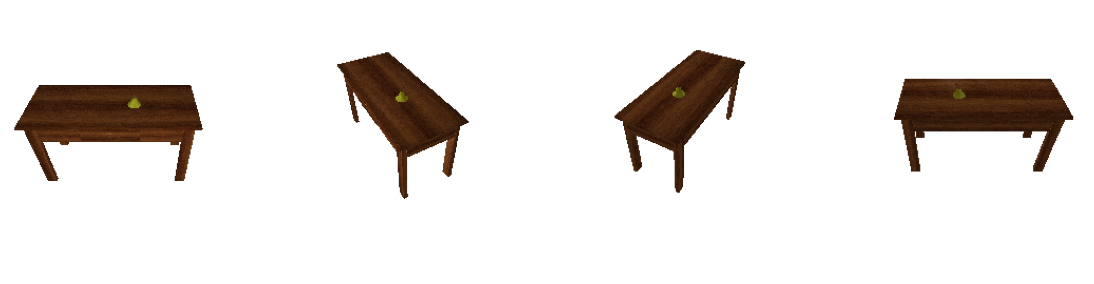

In [35]:
image_grid(_infos["best"]["images"], rows=1, cols=4, rgb=True)

In [14]:
from torch import cuda

env.close()
cuda.empty_cache()